In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from tqdm import tqdm_notebook
import scipy.integrate as integrate
import copy
import seaborn as sns
from pathlib import Path

from mpl_toolkits import mplot3d
from scipy.stats import kde

In [3]:
MODEL_DIRECTORY = Path('../../model/')
MAIN_DIRECTORY = Path('../../')

In [4]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [4]:
# singles_data = read_file(MODEL_DIRECTORY / 'model_separated_singles_500pc_manystars_power2.txt')
# singles_data = singles_data[(singles_data['bp-rp, mag']>0.1) & (singles_data['bp-rp, mag']<0.4)]

In [5]:
# binaries_data = read_file(MODEL_DIRECTORY / 'model_separated_binaries_500pc_manystars_power2.txt')
# binaries_data = binaries_data[(binaries_data['bp-rp, mag']>0.1) & (binaries_data['bp-rp, mag']<0.4)]

In [6]:
# singles_data['g, mag'].min()

10.429456510815148

In [11]:
all_stars = read_file(MODEL_DIRECTORY / 'model_stars_250pc_manystars_flat_no_errors.txt')
all_stars['bp-rp, mag'] = all_stars['BP-RP, mag']
all_stars = all_stars[(all_stars['bp-rp, mag']>0.1) & (all_stars['bp-rp, mag']<0.4)]

In [7]:
# all_stars = pd.concat((singles_data, binaries_data))

In [139]:
 # create data
x = all_stars['bp-rp, mag']
y = all_stars['g, mag']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
f = zi.reshape(xi.shape)

In [140]:
isochrone_f = pd.DataFrame()
for i in range(0, nbins):
    value = f[i,:].max()
    index_y = f[i,:].argmax()
    
    isochrone_f = isochrone_f.append(
                    pd.Series([xi[i,0], yi[0,index_y]]), ignore_index=True)
    

In [141]:
isochrone_f = isochrone_f.rename(columns={0 : 'bp-rp, mag', 1 : 'g, mag'})

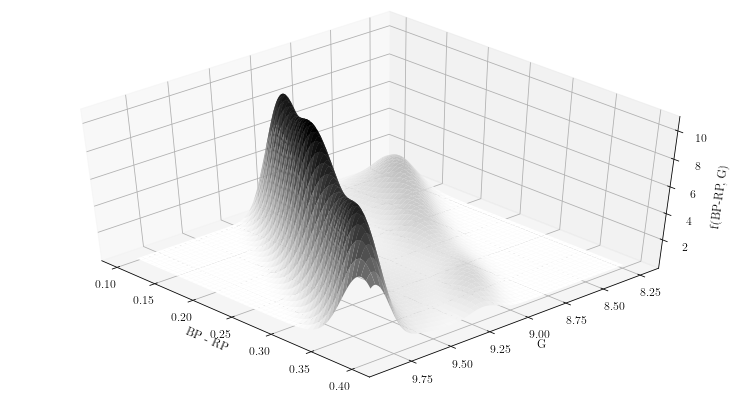

In [142]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xi, yi, zi.reshape(xi.shape), cmap='binary')
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.set_zlabel('f(BP-RP, G)')
ax.invert_yaxis()


ax.view_init(45, 317)

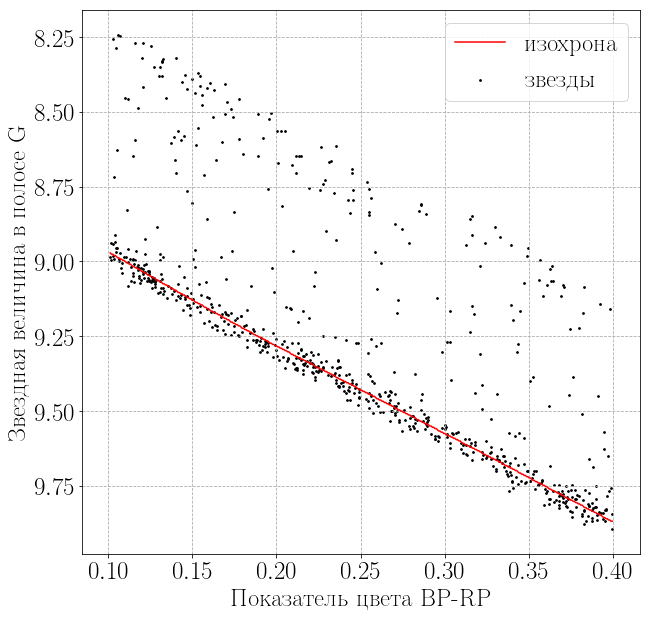

In [162]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter (all_stars['bp-rp, mag'] , all_stars['g, mag'] , c ='black', s = 3, label ='звезды')
ax.plot(isochrone_f['bp-rp, mag'],isochrone_f['g, mag'] , c ='red', lw = 1.5, label ='изохрона') 
ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend()
plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')
plt.show()

In [163]:
func_iso = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag']) 
all_stars['Gmag_new'] = all_stars['g, mag'] - func_iso(all_stars['bp-rp, mag'])

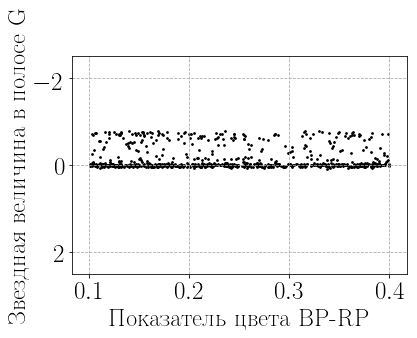

In [164]:
fig, ax = plt.subplots(figsize=(6,4))
# ax.scatter (singles_data['bp-rp, mag'] , singles_data['Gmag_new'] , c ='black', s = 3, label ='звезды')
# ax.scatter (binaries_data['bp-rp, mag'] , binaries_data['Gmag_new'] , c ='red', s = 3, label ='звезды')
ax.scatter (all_stars['bp-rp, mag'] , all_stars['Gmag_new'] , c ='black', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2.5,2.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
#ax.legend(fontsize = 15)
#plt.savefig("horizontal_sequence.pdf", bbox_inches = 'tight')
plt.show()

In [146]:
# all_stars = pd.concat([binaries_data, singles_data])
# all_stars_data = all_stars[all_stars['bp-rp, mag']>0.1]

In [147]:
num_stars = len(all_stars)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.03)
kde.fit(all_stars[['Gmag_new']].to_numpy())

profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile['density'] *= num_stars

Text(0.5, 0, '$G_{new}$')

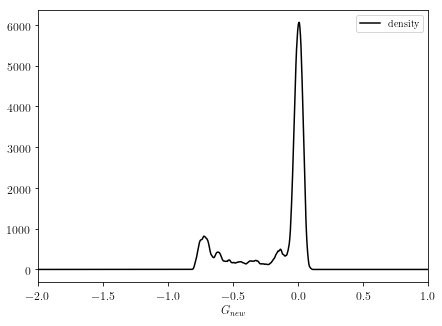

In [148]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

In [149]:
row_max = profile['density'].idxmax()

x_right, y_right = profile.iloc[row_max:, 0].reset_index(drop=True), profile.iloc[row_max:, 1].reset_index(drop=True)

y_left = y_right.sort_index(ascending=False)
y_left = y_left.drop(0)

y_left_whole = np.append([0] * (len(profile['density'].loc[profile['x'] < x_right[0]]) - len(y_left)),
                         y_left)

profile['density_sym'] = np.append(y_left_whole, y_right)

In [150]:
def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-15:row_max+155, 0], profile.iloc[row_max-15:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [30000, profile.iloc[row_max, 0]+0.1, 0.8, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

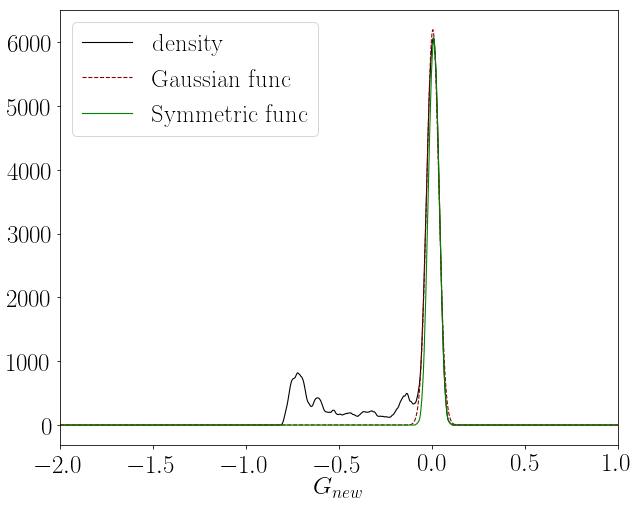

In [167]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(profile['x'], profile['density'], lw = 1.1, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.1, ls='--', color='darkred', label='Gaussian func')

ax.plot(profile['x'], profile['density_sym'], lw = 1.1, ls='-', color='green', label='Symmetric func')


ax.set_xlim(-2, 1)

ax.legend(loc='upper left')
ax.set_xlabel('$G_{new}$')
fig.savefig(f"model_profile_250pc_manystars_flat.pdf", bbox_inches = 'tight')

In [152]:
binaries = all_stars[all_stars['Mass1']>0]

num_stars = len(binaries)
profile_binaries = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.03)
kde.fit(binaries[['Gmag_new']].to_numpy())

profile_binaries['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile_binaries['density'] *= num_stars

In [153]:
singles = all_stars[all_stars['Mass']>0]

num_stars = len(singles)
profile_singles = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.03)
kde.fit(singles[['Gmag_new']].to_numpy())

profile_singles['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile_singles['density'] *= num_stars

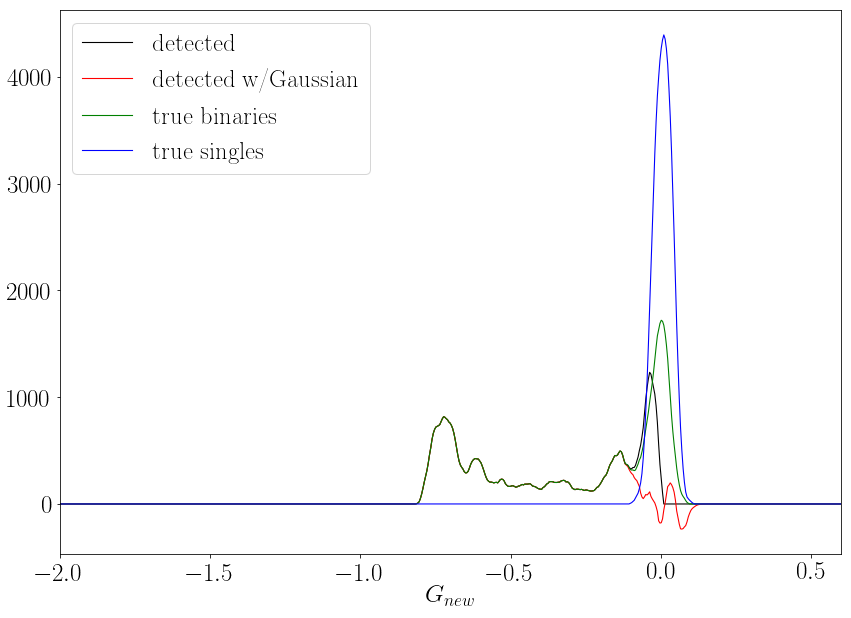

In [168]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(profile['x'], profile['density'] - profile['density_sym'], lw = 1.1, color = 'black', label='detected')
ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 1.1, color = 'red', label='detected w/Gaussian')

ax.plot(profile['x'], profile_binaries['density'], lw = 1.1, color = 'green', label='true binaries')
ax.plot(profile['x'], profile_singles['density'], lw = 1.1, color = 'blue', label='true singles')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper left')
ax.set_xlabel('$G_{new}$')
fig.savefig(f"model_profile_250pc_manystars_flat_binaries.pdf", bbox_inches = 'tight')

In [155]:
difference = profile['density'] - profile['density_sym']
difference[difference < 0] = 0

number_of_multiples = int(integrate.simps(difference, profile['x']))

In [115]:
difference_g = profile['density'] - profile_gauss['density']
difference_g[difference_g < 0] = 0

number_of_multiples_g = int(integrate.simps(difference_g, profile['x']))

In [156]:
# доля двойных из интегрирования профиля
number_of_multiples / len(all_stars)

0.39777468706536856

In [30]:
# доля двойных из "первичного отбора"
len(binaries_data) / (len(binaries_data) + len(singles_data))

0.4599745870393901

In [90]:
len(all_stars[(all_stars['Mass']>0) == False]) / len(all_stars)

0.525062656641604

In [157]:
stars_left = binaries_data[binaries_data['bp-rp, mag'] < 0.75]
stars_centre = binaries_data[(binaries_data['bp-rp, mag'] < 1.5) & (binaries_data['bp-rp, mag'] > 0.75)]
stars_right = binaries_data[binaries_data['bp-rp, mag'] > 1.5]

q_left = stars_left['Mass2'] / stars_left['Mass1']
q_centre = stars_centre['Mass2'] / stars_centre['Mass1']
q_right = stars_right['Mass2'] / stars_right['Mass1']

q_absence = (singles_data['Mass2'] / singles_data['Mass1'])
q = binaries_data['Mass2'] / binaries_data['Mass1']

NameError: name 'binaries_data' is not defined

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


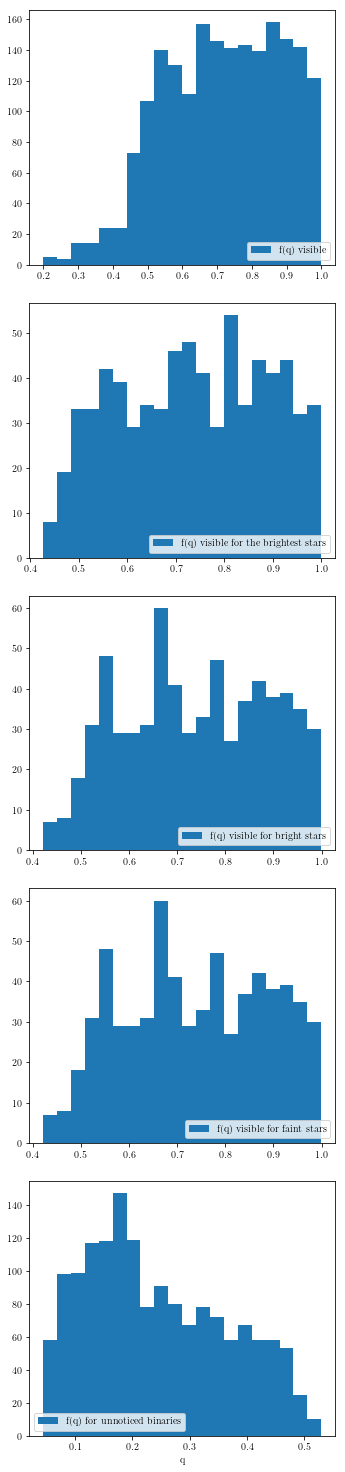

In [96]:
plt.figure(figsize=(5,15))
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[english]{babel}')


plt.subplot(5, 1, 1)
plt.hist(q, bins=20, label=r'f(q) visible')
plt.legend(loc='lower right')

plt.subplot(5, 1, 2)
plt.hist(q_left, bins=20, label=r'f(q) visible for the brightest stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 3)
plt.hist(q_centre, bins=20, label=r'f(q) visible for bright stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 4)
plt.hist(q_centre, bins=20, label=r'f(q) visible for faint stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 5)
plt.hist(q_absence, bins=20, label=r'f(q) for unnoticed binaries')
plt.legend(loc='lower left')

plt.xlabel('q')

plt.subplots_adjust(top=1.4, bottom=0.08, left=0.10, right=0.95, hspace=0.15,wspace=0.2)
#plt.savefig("q_distribution_model_flat.pdf", bbox_inches = 'tight')